# Use Transfer Learning for Sun Spotter
## Try different pre trained models e.g. resnet_v2_152, inception_resnet_v2, mobilenet etc.

In [55]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import time
import PIL.Image as Image
import tensorflow_hub as hub
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Use a pretrained model

### Preparation to make it easy to try out different models

#### Use head-less pretrained Model for CNN
We tried the following models:
* Use trainable=False to freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.   
* Use trainable=True to fine tune the variables in the feature extractor layer.
   
| "Model"        | "Fine tuned?"| "Training loss"  | "Training accuracy"  | "Validation loss" | "Validation accuracy" | "Commments"
| :------------- |:-------------:| :-------------:| :-----: |:-----:| :-----: | ------------- :|
| resnet_v2_50  | yes              |0.7248 | 0.9413  |  0.8801 | 0.8594 | generalizes bad (always 100% confidence in one class)
| resnet_v2_50  | no               |0.8994 |  0.5831  | 0.8569 | 0.5375 |generalizes bad (always 100% confidence in one class)
| inception_resnet_v2   | yes      | 1.0882 | 0.8742 | 1.8426 | 0.5250 |generalizes bad (always 100% confidence in one class)
| inception_resnet_v2   | no      |   0.6287 |0.8308  | 0.9929 | 0.6219 |generalizes bad (always 100% confidence in one class)
| mobilenet_v2_140_224| yes      |   0.5639| 0.9345 |  1.0495 | 0.6125 | second best results
| mobilenet_v2_140_224| no      |  0.6338 |0.9345  |0.7113 | 0.7750 | **_best validation loss & generalizes best_**

#### Own CNN-Model with 5 convolution layers
| "Model"        | "Fine tuned?"| "Training loss"  | "Training accuracy"  | "Validation loss" | "Validation accuracy" | "Commments"
| :------------- |:-------------:| :-------------:| :-----: |:-----:| :-----: | ------------- :|
| selfmade model  | -              | 0.3565 |  0.8442  |  0.3142 | 0.8592 | lowest loss and high accuracy but generalizes not good



In [56]:
model_name = "mobilenet_v2_140_224" # @param ['bit_s-r50x1', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'inception_v3', 'inception_resnet_v2', 'mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152']

model_handle_map = {
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature_vector/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature_vector/4",  
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature_vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature_vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature_vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/4",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/4",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4",
}

model_image_size_map = {
  "efficientnet_b0": 224,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 32 #@param {type:"integer"}

Selected model: mobilenet_v2_140_224 : https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/4
Input size (224, 224)


## Create callback instances
### Setup folder where to save logs for tensorboard, one folder for every run

In [57]:
#setup folder where to save logs for tensorflow
root_logdir = os.path.join(os.curdir,"my_logs")

def get_run_logdir(modelName):
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S_"+modelName)
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir(model_name)

In [58]:
#create keras Tensorboard callback
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

### Setup callback for ModelCheckpoint to save the model

In [59]:
#create keras ModelCheckpoint callback
checkpoint_cb = keras.callbacks.ModelCheckpoint("sunSpotter_keras_transferLearning_model.h5")

### Setup callback for Early Stopping

In [60]:
#create keras early stopping callback will be used later on
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

### Load the data set

We uses a dataset of about 735 sunny photos and 854 not sunny of different landscapes from real webcams. The dataset contains 2 sub-directories, one per class:

```
/
  notSunny/
  sunny/  
```

In [61]:
import pathlib
data_dir = "..\..\data\images-classified"
data_dir = pathlib.Path(data_dir)
print(data_dir)

testData_dir = "..\..\\testData\images-classified"
testData_dir = pathlib.Path(testData_dir)
print(testData_dir)

..\..\data\images-classified
..\..\testData\images-classified


Load and preprocess the data set (in the code under it assumes that every class is contained in a different subfolder, but that can be adapted). In addition perform some data augmentation on the training data. 
Split the dataset in a validation an a training part which will be used by the model. Let's use 80% of the images for training, and 20% for validation. Use a second source as test data. The items for test are situated in a separate folder.


mobile-net, den kleineren verwenend (noch kein fine tuning)
nur 1 dropout layer bevor dense
30% 40% dropout

In [62]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, validation_split=.20)# add data augmentation transformations
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255, validation_split=.20)#no data augmentation in the validation set
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)#no data augmentation in the test set    

train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True,target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")
test_generator = test_datagen.flow_from_directory(
    testData_dir, shuffle=False, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
                   interpolation="bilinear")         

Found 1112 images belonging to 2 classes.
Found 277 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


### Defining the model

First let's create the feature extractor. Use trainable=False to freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [63]:
feature_extractor_layer = hub.KerasLayer(model_handle, trainable=False)

Now let's attach a classification head after the feature extractor layer. Thta's mean we need to wrap the hub layer 
in a tf.keras.Sequential model, and add a new classification layer.

For speed, we start out with a non-trainable feature_extractor_layer, but you can also enable fine-tuning for greater accuracy. Just change to trainable = True.  

In [64]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    feature_extractor_layer,
    #tf.keras.layers.Dropout(rate=0.2),    
    tf.keras.layers.Dense(units=128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dropout(rate=0.2),
    layers.Dense(units=64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    layers.Dropout(rate=0.2),
    #layers.Dense(units=train_generator.num_classes, activation='softmax')
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1792)              4363712   
_________________________________________________________________
dense_3 (Dense)              (None, 128)               229504    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 4,601,602
Trainable params: 237,890
Non-trainable params: 4,363,712
______________________________________

### Compile & Train the model 

In [65]:
model.compile(
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9), 
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
  metrics=['accuracy'])

In [66]:
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size
epochs = 8
hist = model.fit(
    train_generator,
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    validation_data=valid_generator,
    validation_steps=validation_steps,  callbacks = [tensorboard_cb, early_stopping_cb, checkpoint_cb]).history

Epoch 1/8


C:\Users\maryl\anaconda3\lib\site-packages\keras\backend.py:4846: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  warnings.warn(


34/34 [==============================] - 64s 2s/step - loss: 0.6508 - accuracy: 0.6954 - val_loss: 0.5320 - val_accuracy: 0.7891
Epoch 2/8
34/34 [==============================] - 46s 1s/step - loss: 0.4383 - accuracy: 0.8704 - val_loss: 0.4006 - val_accuracy: 0.8711
Epoch 3/8
34/34 [==============================] - 61s 2s/step - loss: 0.3834 - accuracy: 0.9167 - val_loss: 0.4474 - val_accuracy: 0.8633
Epoch 4/8
34/34 [==============================] - 67s 2s/step - loss: 0.3610 - accuracy: 0.9380 - val_loss: 0.3719 - val_accuracy: 0.9180
Epoch 5/8
34/34 [==============================] - 57s 2s/step - loss: 0.3442 - accuracy: 0.9426 - val_loss: 0.4751 - val_accuracy: 0.8594
Epoch 6/8
34/34 [==============================] - 45s 1s/step - loss: 0.3363 - accuracy: 0.9435 - val_loss: 0.4331 - val_accuracy: 0.8867
Epoch 7/8
34/34 [==============================] - 67s 2s/step - loss: 0.3156 - accuracy: 0.9620 - val_loss: 0.4183 - val_accuracy: 0.8867
Epoch 8/8
34/34 [====================

Let's track the training (one can also use TensorBoard!)

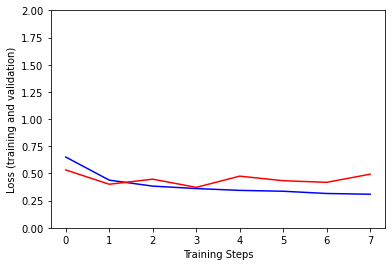

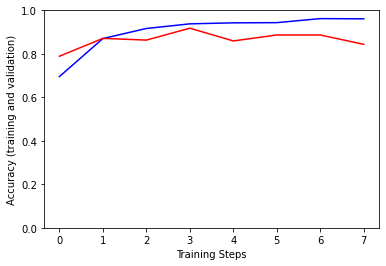

In [67]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"], color="blue", label='Training Loss')
plt.plot(hist["val_loss"], color="red", label='Validation Loss')

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"], color="blue", label='Training Loss')
plt.plot(hist["val_accuracy"], color="red", label='Validation Loss')

Create plots of loss and accuracy on the training and validation sets.

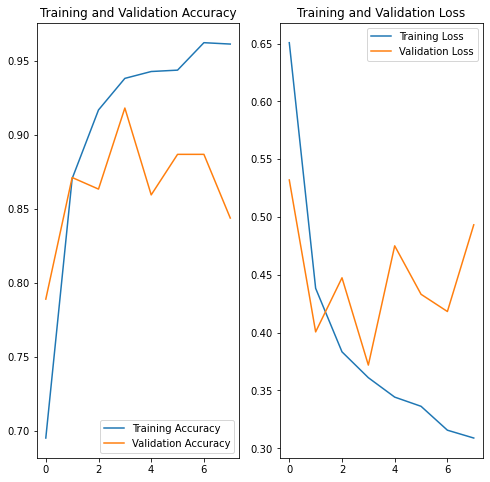

In [68]:
acc = hist['accuracy']
val_acc = hist['val_accuracy']

loss = hist['loss']
val_loss = hist['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Reload a pretrained model

In [77]:
# Reconstruct the model with keras
# model_name_toreload = "mobilenet_v2_140_224"
# pretrained_model_path = f"./tmp/saved_sunSpotter_model_{model_name}"

#H5 format
#pretrained_model_path = f"./sunSpotter_keras_transferLearning_model_mobilenet_v2_140_224_finetuned.h5"
# pretrained_model_path = f"./sunSpotter_keras_transferLearning_model_mobilenet_v2_140_224.h5"
pretrained_model_path = f"sunSpotter_keras_transferLearning_model.h5"
model = keras.models.load_model(pretrained_model_path, custom_objects={'KerasLayer':hub.KerasLayer})
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1792)              4363712   
_________________________________________________________________
dense_3 (Dense)              (None, 128)               229504    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 130       
Total params: 4,601,602
Trainable params: 237,890
Non-trainable params: 4,363,712
______________________________________

## Predict on trainings data

Try out the model on an image from the validation data:

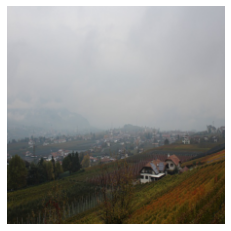

True label: notSunny
Predicted label: notSunny


In [104]:
def get_class_string_from_index(index):
   for class_string, class_index in valid_generator.class_indices.items():
      if class_index == index:
         return class_string

x, y = next(valid_generator)
image = x[0, :, :, :]
true_index = np.argmax(y[0])
plt.imshow(image)
plt.axis('off')
plt.show()

# Expand the validation image to (1, 224, 224, 3) before predicting the label
prediction_scores = model.predict(np.expand_dims(image, axis=0))
predicted_index = np.argmax(prediction_scores)
print("True label: " + get_class_string_from_index(true_index))
print("Predicted label: " + get_class_string_from_index(predicted_index))

show the confidence level of the preditions (most likely and least likely):

In [79]:
score = tf.nn.softmax(prediction_scores[0])
# print score of all classes
print(score)
# print score of most likely class
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(get_class_string_from_index(np.argmax(score)), 100 * np.max(score))
)
# pring score of least likely class
print(
    "This image most unlikely belongs to {} with a {:.2f} percent confidence."
    .format(get_class_string_from_index(np.argmin(score)), 100 * np.min(score))
)

tf.Tensor([0.7050322 0.2949678], shape=(2,), dtype=float32)
This image most likely belongs to notSunny with a 70.50 percent confidence.
This image most unlikely belongs to sunny with a 29.50 percent confidence.


## Predict on new data

Result is unfortunately pretty bad, it doesnt matter if we choose a picture where there is sun or rain, it always predicts the th same class with a 100% confidence. 

Number of test data: 200
Found 200 files belonging to 2 classes.
['notSunny', 'sunny']
<class 'numpy.ndarray'>
True labels: 
[0 0 1 1 1 1 0 0 0 1 0 0 0 0 0 1 1 1 1 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 0 0
 0 1 0 1 0 0 0 1 1 0 0 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0 0 0 0 1 0 1 1 0 1 0 1
 0 0 1 1 0 1 0 1 1 0 0 0 1 0 1 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 1 0 0 0 1 1 0
 1 0 0 0 0 0 0 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 0
 1 1 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 1
 0 1 1 0 0 0 1 0 0 1 0 0 1 1 1]
Predicted labels: 
[1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 0 1 1 1 1 1 0
 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1
 0 1 1 0 1 0 1 0 1 1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1
 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1
 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 0 0 0 0 1 1
 1 1 0 0 0 0 0 1 1 0 1 1 0 1 1]


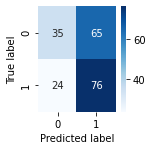

In [92]:
#load test dataset with function image_dataset_from_directory
image_test_count = len(list(testData_dir.glob('*/*.jpg'))) 
print("Number of test data: {}".format(image_test_count))
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    testData_dir,
    seed=123,
    image_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    batch_size=BATCH_SIZE)
#AUTOTUNE = tf.data.AUTOTUNE
#test_ds =  test_ds.cache().prefetch(buffer_size=AUTOTUNE)

class_names = test_ds.class_names
print(class_names)

#print(test_ds)
y = np.concatenate([y for x, y in test_ds], axis=0)
print(type(y))
print("True labels: \n{}".format(y))

predictions = model.predict(test_ds)
scores = np.empty_like(y)

#print(y.size)
#print(len(predictions))
#print(scores.size)

for i in range(len(predictions)):
  score = tf.nn.softmax(predictions[i])
  scores[i] = np.argmax(score)
  #print(scores[i])

print("Predicted labels: \n{}".format((scores)))

con_mat_df = tf.math.confusion_matrix(labels= y, predictions = scores)

import seaborn as sns
figure = plt.figure(figsize=(2, 2))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Confusion Matrix
[[61 39]
 [ 6 94]]
Classification Report
              precision    recall  f1-score   support

   not Sunny       0.91      0.61      0.73       100
       Sunny       0.71      0.94      0.81       100

    accuracy                           0.78       200
   macro avg       0.81      0.77      0.77       200
weighted avg       0.81      0.78      0.77       200



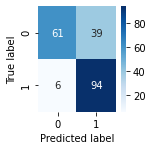

In [93]:
#Confution Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(test_generator, 200 // BATCH_SIZE+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
con_mat_df = confusion_matrix(test_generator.classes, y_pred)
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['not Sunny', 'Sunny']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

figure = plt.figure(figsize=(2, 2))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [85]:
#sunny_url = https://www.foto-webcam.eu/webcam/tschagguns/2021/06/01/1140_hu.jpg
#sunny_url = https://www.foto-webcam.eu/webcam/tschagguns/2021/05/28/1510_hu.jpg
#sunny_url = "https://www.foto-webcam.eu/webcam/tschagguns/2021/06/01/1140_hu.jpg"
#sunny_url = "https://www.foto-webcam.eu/webcam/schroecken/2021/06/09/0830_lm.jpg"
#sunny_url = "https://www.foto-webcam.eu/webcam/feldkirch/2021/06/13/0910_lm.jpg"
sunny_url = "https://www.foto-webcam.eu/webcam/brunnen/2021/06/09/0830_lm.jpg"

sunny_path = tf.keras.utils.get_file('SunnyWheater', origin=sunny_url)

img = keras.preprocessing.image.load_img(
    sunny_path, target_size=(IMAGE_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(score)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(get_class_string_from_index(np.argmax(score)), 100 * np.max(score))
)

print(
    "This image most unlikely belongs to {} with a {:.2f} percent confidence."
    .format(get_class_string_from_index(np.argmin(score)), 100 * np.min(score))
)

tf.Tensor([0.5368174 0.4631826], shape=(2,), dtype=float32)
This image most likely belongs to notSunny with a 53.68 percent confidence.
This image most unlikely belongs to sunny with a 46.32 percent confidence.


In [86]:
cloudy_url = "https://www.foto-webcam.eu/webcam/tschagguns/2021/05/27/1510_hu.jpg"
#cloudy_url = "https://www.foto-webcam.eu/webcam/roethis-west/current/180.jpg?1623220198"
#cloudy_url = "https://www.foto-webcam.eu/webcam/saalfelden/2021/06/13/0920_lm.jpg"
#cloudy_url = "https://www.foto-webcam.eu/webcam/zellamsee/2021/06/13/0920_lm.jpg"
#cloudy_url = "https://www.foto-webcam.eu/webcam/burgstalleralm/2021/06/13/0920_lm.jpg"

cloudy_path = tf.keras.utils.get_file('CloudyWheater', origin=cloudy_url)

img = keras.preprocessing.image.load_img(
    cloudy_path, target_size=(IMAGE_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(score)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(get_class_string_from_index(np.argmax(score)), 100 * np.max(score))
)

print(
    "This image most unlikely belongs to {} with a {:.2f} percent confidence."
    .format(get_class_string_from_index(np.argmin(score)), 100 * np.min(score))
)

tf.Tensor([0.5706207  0.42937928], shape=(2,), dtype=float32)
This image most likely belongs to notSunny with a 57.06 percent confidence.
This image most unlikely belongs to sunny with a 42.94 percent confidence.


In [87]:
#rainy_url = "https://www.foto-webcam.eu/webcam/zugspitze-nord/2021/06/13/0910_lm.jpg"
#rainy_url = "https://www.foto-webcam.eu/webcam/kalsertal/2021/06/13/0920_lm.jpg"
rainy_url = "https://www.foto-webcam.eu/webcam/pendling-west/2021/06/13/0920_lm.jpg"
rainy_path = tf.keras.utils.get_file('RainyWheater', origin=rainy_url)

img = keras.preprocessing.image.load_img(
    rainy_path, target_size=(IMAGE_SIZE)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(score)
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(get_class_string_from_index(np.argmax(score)), 100 * np.max(score))
)

print(
    "This image most unlikely belongs to {} with a {:.2f} percent confidence."
    .format(get_class_string_from_index(np.argmin(score)), 100 * np.min(score))
)

tf.Tensor([0.6365326 0.3634674], shape=(2,), dtype=float32)
This image most likely belongs to notSunny with a 63.65 percent confidence.
This image most unlikely belongs to sunny with a 36.35 percent confidence.


## Save the model

In [77]:
saved_model_path = f"./tmp/saved_sunSpotter_model_{model_name}"
tf.saved_model.save(model, saved_model_path)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: ./tmp/saved_sunSpotter_model_mobilenet_v2_140_224\assets
INFO:tensorflow:Assets written to: ./tmp/saved_sunSpotter_model_mobilenet_v2_140_224\assets


In [78]:
#Sources: Adapted from A. Géron, Hands-on Machine Learning with Scikit-Learn, Keras, Tensorflow, O’Reilly, 
#https://www.tensorflow.org/hub/tutorials/tf2_image_retraining, https://www.tensorflow.org/tutorials/images/transfer_learning